In [59]:
# Statistics modules
import scipy.stats as st

# Datetime class
from datetime import date
from datetime import datetime

import pandas as pd # dataframe manipulation
import numpy as np # linear algebra

# data visualization
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import shap

# sklearn 
from sklearn.cluster import KMeans
from sklearn.preprocessing import PowerTransformer, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, silhouette_samples, accuracy_score, classification_report

from pyod.models.ecod import ECOD
from yellowbrick.cluster import KElbowVisualizer

import lightgbm as lgb
import prince

sns.set_theme()   
sns.set(color_codes=True)

In [60]:
crime_data = pd.read_csv('crime_data.csv')

## Data Transformation

In [63]:
crime_data['Assault date'] = pd.to_datetime(crime_data['Assault date'])
crime_data = crime_data[crime_data['Assault date'].dt.strftime('%Y') == '2023']

In [64]:
crime_data = crime_data.drop(columns=['Div_Records_No', 'Date reported', 'Assault date', 'Assault time', 'Geographic area', 'Area name', 'Reported District No', 
                                      'Crime committed', 'Crime location code', 'Crime location', 'Assault weapon code', 'Assault weapon', 'Status code', 
                                      'Investigation status', 'Crime code 1', 'Crime code 2', 'Crime code 3', 'Crime code 4', 'Address', 'Latitude', 'Longitude'])

In [67]:
# Analyzing the various types of crime and their counts.

# types_of_crimes = crime_data['Crime description'].value_counts()
# types_of_crimes.head()

In [68]:
crimes_in_focus = ['BATTERY - SIMPLE ASSAULT', 'THEFT OF IDENTITY', 'BURGLARY FROM VEHICLE', 'ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT',
                    'INTIMATE PARTNER - SIMPLE ASSAULT', 'VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)', 
                    'THEFT PLAIN - PETTY ($950 & UNDER)', 'BURGLARY', 'THEFT FROM MOTOR VEHICLE - GRAND ($950.01 AND OVER)',
                    'ROBBERY', 'VANDALISM - MISDEAMEANOR ($399 OR UNDER)', 'CRIMINAL THREATS - NO WEAPON DISPLAYED']

crime_data_subset = crime_data['Crime description'].isin(crimes_in_focus)
model_data = crime_data[crime_data_subset]
model_data.head()

,Crime description,Victim's age,Victim's sex,Victim's race
477904,THEFT PLAIN - PETTY ($950 & UNDER),48,M,H
477905,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",36,F,W
477906,THEFT FROM MOTOR VEHICLE - GRAND ($950.01 AND ...,25,F,H
477909,INTIMATE PARTNER - SIMPLE ASSAULT,30,F,H
477910,THEFT PLAIN - PETTY ($950 & UNDER),63,F,B


In [69]:
model_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84979 entries, 477904 to 595254
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Crime description  84979 non-null  object
 1   Victim's age       84979 non-null  int64 
 2   Victim's sex       84976 non-null  object
 3   Victim's race      84975 non-null  object
dtypes: int64(1), object(3)
memory usage: 3.2+ MB


In [70]:
model_data.nunique()

Crime description    12
Victim's age         98
Victim's sex          2
Victim's race        18
dtype: int64

In [71]:
new_names = {
    'BATTERY - SIMPLE ASSAULT': 'battery_simple_assault',
    'THEFT OF IDENTITY': 'identity_theft',
    'INTIMATE PARTNER - SIMPLE ASSAULT': 'gender_violence',
    'BURGLARY FROM VEHICLE': 'vehicular_break_and_entering',
    'ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT': 'aggravated_assault_deadly_weapon',
    'VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)': 'vandalism_felony',
    'THEFT PLAIN - PETTY ($950 & UNDER)': 'petty_theft',
    'ROBBERY': 'robbery',
    'BURGLARY': 'breaking_and_entering',
    'VANDALISM - MISDEAMEANOR ($399 OR UNDER)': 'vandalism_misdeameanor',
    'CRIMINAL THREATS - NO WEAPON DISPLAYED': 'criminal_threats'
}

# Use the mapping dictionary to replace names in the 'Names' column
model_data['Crime description'] = model_data['Crime description'].map(new_names)

C:\Users\Victor Jr\AppData\Local\Temp\ipykernel_102012\2874563932.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [72]:
model_data.to_csv('model_data.csv')

## Model Building

### The LLM + Kmeans model is used for crime segmentation (classification by clustering)

In [73]:
# I don't really have an explanation for doing this. The code was initially giving me a bunch of errors, so I tried to follow exactly how it was done.

model_data = model_data.iloc[:, :]

In [74]:
# Since our problem is a classification problem with more than one categorical variables, the method of transforming the text into numerical vectors is the 
# Sentence Embedding (LLM). Providing input to the information-rich Kmeans model, will return better predictions.
# The code is in a different python script.

embedded_model_data = pd.read_csv('embedded_model_data.csv')

In [76]:
# Functions to be called for plotting PCA 2D and 3D plots
    
# Not essential to understand or comprehend
    
def get_pca_2d(df, predict):

    pca_2d_object = prince.PCA(
    n_components=2,
    n_iter=3,
    rescale_with_mean=True,
    rescale_with_std=True,
    copy=True,
    check_input=True,
    engine='sklearn',
    random_state=42
    )

    pca_2d_object.fit(df)

    df_pca_2d = pca_2d_object.transform(df)
    df_pca_2d.columns = ["comp1", "comp2"]
    df_pca_2d["cluster"] = predict

    return pca_2d_object, df_pca_2d



def get_pca_3d(df, predict):

    pca_3d_object = prince.PCA(
    n_components=3,
    n_iter=3,
    rescale_with_mean=True,
    rescale_with_std=True,
    copy=True,
    check_input=True,
    engine='sklearn',
    random_state=42
    )

    pca_3d_object.fit(df)

    df_pca_3d = pca_3d_object.transform(df)
    df_pca_3d.columns = ["comp1", "comp2", "comp3"]
    df_pca_3d["cluster"] = predict

    return pca_3d_object, df_pca_3d



def plot_pca_3d(df, title = "PCA Space", opacity=0.8, width_line = 0.1):

    df = df.astype({"cluster": "object"})
    df = df.sort_values("cluster")

    fig = px.scatter_3d(df, 
                        x='comp1', 
                        y='comp2', 
                        z='comp3',
                        color='cluster',
                        template="plotly",
                        
                        # symbol = "cluster",
                        
                        color_discrete_sequence=px.colors.qualitative.Vivid,
                        title=title).update_traces(
                            # mode = 'markers',
                            marker={
                                "size": 4,
                                "opacity": opacity,
                                # "symbol" : "diamond",
                                "line": {
                                    "width": width_line,
                                    "color": "black",
                                }
                            }
                        ).update_layout(
                                width = 1000, 
                                height = 800, 
                                autosize = False, 
                                showlegend = True,
                                legend=dict(title_font_family="Times New Roman",
                                            font=dict(size= 20)),
                                scene = dict(xaxis=dict(title = 'comp1', titlefont_color = 'black'),
                                            yaxis=dict(title = 'comp2', titlefont_color = 'black'),
                                            zaxis=dict(title = 'comp3', titlefont_color = 'black')),
                                font = dict(family = "Gilroy", color  = 'black', size = 15))
                      
    
    fig.show()


def plot_pca_2d(df, title = "PCA Space", opacity=0.8, width_line = 0.1):

    df = df.astype({"cluster": "object"})
    df = df.sort_values("cluster")

    fig = px.scatter(df, 
                        x='comp1', 
                        y='comp2', 
                        color='cluster',
                        template="plotly",
                        # symbol = "cluster",
                        
                        color_discrete_sequence=px.colors.qualitative.Vivid,
                        title=title).update_traces(
                            # mode = 'markers',
                            marker={
                                "size": 8,
                                "opacity": opacity,
                                # "symbol" : "diamond",
                                "line": {
                                    "width": width_line,
                                    "color": "black",
                                }
                            }
                        ).update_layout(
                                width = 800, 
                                height = 700, 
                                autosize = False, 
                                showlegend = True,
                                legend=dict(title_font_family="Times New Roman",
                                            font=dict(size= 20)),
                                scene = dict(xaxis=dict(title = 'comp1', titlefont_color = 'black'),
                                            yaxis=dict(title = 'comp2', titlefont_color = 'black'),
                                            ),
                                font = dict(family = "Gilroy", color  = 'black', size = 15))
                        
        
    fig.show()

In [77]:
# This is the Python Outlier Detection (PyOD) library for detecting outliers for different cases. 
# The ECOD method (“empirical cumulative distribution functions for outlier detection”) is the specific method used.

clf = ECOD()
clf.fit(embedded_model_data)


out = clf.predict(embedded_model_data) 
embedded_model_data["outliers"] = out
model_data["outliers"] = out

embedded_model_data_no_out = embedded_model_data[embedded_model_data["outliers"] == 0]
embedded_model_data_no_out = embedded_model_data_no_out.drop(["outliers"], axis = 1)


embedded_model_data_with_out = embedded_model_data.copy()
embedded_model_data_with_out = embedded_model_data_with_out.drop(["outliers"], axis = 1)

C:\Users\Victor Jr\AppData\Local\Temp\ipykernel_102012\1010830841.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [78]:
embedded_model_data_no_out.shape

(76502, 384)

In [79]:
embedded_model_data_with_out.shape

(84979, 384)

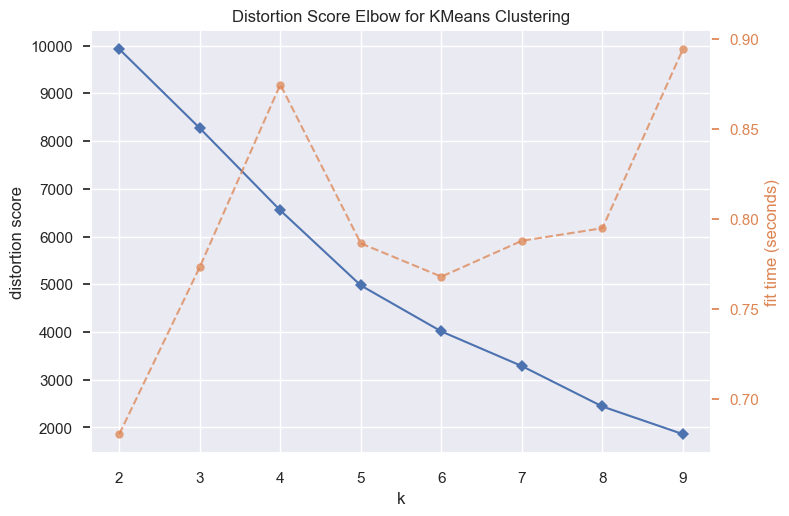

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [80]:
# Instantiate the clustering model and visualizer

km = KMeans(init="k-means++", random_state=0, n_init="auto")
visualizer = KElbowVisualizer(km, k=(2,10), locate_elbow=False)
 
visualizer.fit(embedded_model_data_no_out)        # Fit the data to the visualizer
visualizer.show()

In [82]:
# Fitting the features and target to the Kmeans model

n_clusters = 5

clusters = KMeans(n_clusters=n_clusters, init = "k-means++").fit(embedded_model_data_no_out)
print(clusters.inertia_)
clusters_predict = clusters.predict(embedded_model_data_no_out)

c:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



4884.212406170385


In [83]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score

"""
The Davies Bouldin index is defined as the average similarity measure of each cluster with its most similar cluster, where similarity is the ratio of 
within-cluster distances to between-cluster distances.
The minimum value of the DB Index is 0, whereas a smaller value (closer to 0) represents a better model that produces better clusters.
"""
print(f"Davies bouldin score: {davies_bouldin_score(embedded_model_data_no_out, clusters_predict)}")

"""
Calinski Harabaz Index -> Variance Ratio Criterion.
Calinski Harabaz Index is defined as the ratio of the sum of between-cluster dispersion and of within-cluster dispersion.
The higher the index the more separable the clusters.
"""
print(f"Calinski Score: {calinski_harabasz_score(embedded_model_data_no_out, clusters_predict)}")


"""
The silhouette score is a metric used to calculate the goodness of fit of a clustering algorithm, but can also be used as a method for determining an 
optimal value of k (see here for more).
Its value ranges from -1 to 1.
A value of 0 indicates clusters are overlapping and either the data or the value of k is incorrect.
1 is the ideal value and indicates that clusters are very dense and nicely separated.
"""
print(f"Silhouette Score: {silhouette_score(embedded_model_data_no_out, clusters_predict)}")

Davies bouldin score: 1.1357047668384996
Calinski Score: 30048.24972423338
Silhouette Score: 0.45383385056016956


In [84]:
# This code takes into account the variability contained in the first 3 components of the PCA analysis.
# A value close to 80% is usually ideal.

pca_3d_object, df_pca_3d = get_pca_3d(embedded_model_data_no_out, clusters_predict)
# plot_pca_3d(df_pca_3d, title = "PCA Space", opacity=1, width_line = 0.1) # 3D plot of PCA
print("The variability is :", pca_3d_object.eigenvalues_summary)

The variability is :           eigenvalue % of variance % of variance (cumulative)
component                                                    
0             77.724        20.24%                     20.24%
1             52.886        13.77%                     34.01%
2             50.492        13.15%                     47.16%


In [ ]:
# pca_2d_object, df_pca_2d = get_pca_2d(embedded_model_data_with_out, clusters_predict)
# plot_pca_2d(df_pca_2d, title = "PCA Space", opacity=1, width_line = 0.2)

In [ ]:
sampling_data = embedded_model_data_no_out.sample(frac=0.5, replace=True, random_state=1)
sampling_clusters = pd.DataFrame(clusters_predict).sample(frac=0.5, replace=True, random_state=1)[0].values

# 3D plot of t-SNE

# df_tsne_3d = TSNE(
#                   n_components=3, 
#                   learning_rate=500, 
#                   init='random', 
#                   perplexity=200, 
#                   n_iter = 5000).fit_transform(sampling_data)

# df_tsne_3d = pd.DataFrame(df_tsne_3d, columns=["comp1", "comp2",'comp3'])
# df_tsne_3d["cluster"] = sampling_clusters
# plot_pca_3d(df_tsne_3d, title = "T-SNE Space", opacity=1, width_line = 0.1)


# 2D Plot of t-SNE

df_tsne_2d = TSNE(
                  n_components=2, 
                  learning_rate=500, 
                  init='random', 
                  perplexity=200, 
                  n_iter = 5000).fit_transform(sampling_data)

df_tsne_2d = pd.DataFrame(df_tsne_2d, columns=["comp1", "comp2"])
df_tsne_2d["cluster"] = sampling_clusters

plot_pca_2d(df_tsne_2d, title = "T-SNE Space", opacity=0.5, width_line = 0.5)

In [86]:
model_data_no_outliers = model_data[model_data["outliers"] == 0]
model_data_no_outliers = model_data_no_outliers.drop("outliers", axis = 1)

[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000640 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 132
[LightGBM] [Info] Number of data points in the train set: 76502, number of used features: 4
[LightGBM] [Info] Start training from score -2.326824
[LightGBM] [Info] Start training from score -1.554097
[LightGBM] [Info] Start training from score -1.757100
[LightGBM] [Info] Start training from score -1.742286
[LightGBM] [Info] Start training from score -1.069003
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

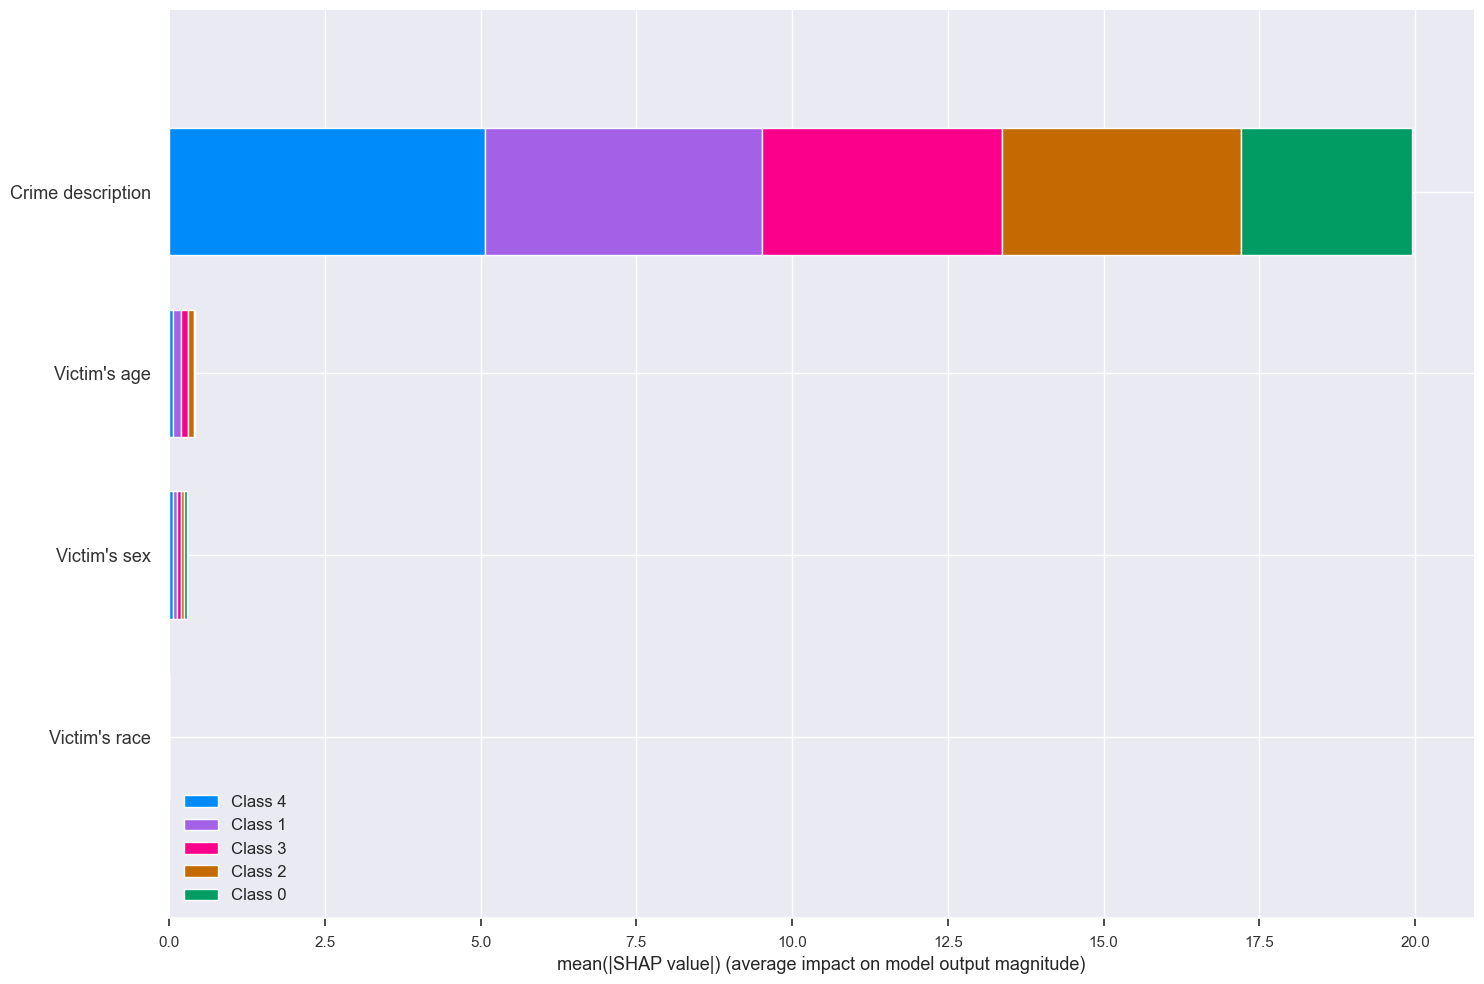

In [87]:
clf_km = lgb.LGBMClassifier(colsample_by_tree=0.8)

for col in ["Crime description", "Victim's sex", "Victim's race"]:
    model_data_no_outliers[col] = model_data_no_outliers[col].astype('category')

clf_km.fit(X=model_data_no_outliers, y=clusters_predict)

#SHAP values
explainer_km = shap.TreeExplainer(clf_km)
shap_values_km = explainer_km.shap_values(model_data_no_outliers)
shap.summary_plot(shap_values_km, model_data_no_outliers, plot_type="bar", plot_size=(15, 10))

In [88]:
y_pred = clf_km.predict(model_data_no_outliers)
accuracy = accuracy_score(y_pred, clusters_predict)
print('Training-set accuracy score: {0:0.4f}'. format(accuracy))
print(classification_report(clusters_predict, y_pred))

[LightGBM] [Warning] Unknown parameter: colsample_by_tree
Training-set accuracy score: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7467
           1       1.00      1.00      1.00     16171
           2       1.00      1.00      1.00     13200
           3       1.00      1.00      1.00     13397
           4       1.00      1.00      1.00     26267

    accuracy                           1.00     76502
   macro avg       1.00      1.00      1.00     76502
weighted avg       1.00      1.00      1.00     76502



In [89]:
model_data_no_outliers["cluster"] = clusters_predict

model_data_group = model_data_no_outliers.groupby('cluster').agg(
    {
        "Crime description": lambda x: x.value_counts().index[0],
        "Victim's age": 'mean',
        "Victim's sex": lambda x: x.value_counts().index[0],
        "Victim's race": lambda x: x.value_counts().index[0],
        
    }
).sort_values("Crime description").reset_index()
model_data_group

,cluster,Crime description,Victim's age,Victim's sex,Victim's race
0,1,aggravated_assault_deadly_weapon,36.607507,M,H
1,2,battery_simple_assault,40.429697,M,H
2,4,identity_theft,40.027601,M,H
3,0,vandalism_felony,42.038302,M,H
4,3,vehicular_break_and_entering,44.230723,M,W
